## Reinforcement Learning Cab Driver Case Study :---


## Team Members
 
     1. Amrit Pattanayak (Group Facilitator)
     2. Kinchit Jain 

## Problem Statement :---

You are hired as a Sr. Machine Learning Er. at SuperCabs, a leading app-based cab provider in a large Indian metro city. In this highly competitive industry, retention of good cab drivers is a crucial business driver, and you believe that a sound RL-based system for assisting cab drivers can potentially retain and attract new cab drivers. 


Cab drivers, like most people, are incentivised by a healthy growth in income. The goal of your project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.



## Goals of the Project :---

  1. Create the environment ‘Env.py’
  2. Build an agent that learns to pick the best request using DQN. You can choose the hyperparameters (epsilon (decay rate), learning-rate, discount factor etc.) of your choice.
  3. Convergence- You need to converge your results. The Q-values may be suboptimal since the agent won't be able to explore much in 5-6 hours of simulation. But it is important that your Q-values converge. There are two ways to check the convergence of the DQN model

### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
from itertools import permutations

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.
G:\USERS\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
G:\USERS\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
G:\USERS\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
G:\USERS\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym o

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

### Lets check the max, min and mean time values. This will help us in defining the 'next_step' function in the Environment.

In [3]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


#### Observation :-----

    The max time is 11 hours and the minimum time is 0 hours between any 2 points. This indicates that the next state of the       cab driver may increase at most by 1 day.


#### Tracking the state-action pairs for checking convergence


In [8]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [12]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor =0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        #self.epsilon_decay = 0.99
        #self.epsilon_min = 0.01
        self.epsilon_decay = -0.0005 #for 15k episodes
        self.epsilon_min = 0.00001
        
        self.batch_size = 32
        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)
        

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets  
        
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, state, possible_actions_index, actions):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            action = random.choice(possible_actions_index)
            return action
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)
            
            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]
        
        
    def append_sample(self, state, action_index, reward, next_state, done):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action_index, reward, next_state, done))   
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))# write here
            update_input =  np.zeros((self.batch_size, self.state_size))# write here
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean  = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)
                
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)                
                
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)
                
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):                
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0) 


    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])

    def save(self, name):
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)
            
            

### DQN block

In [13]:
# Lets find out the episode time before which the car has to be recharged

episode_time = 24*30 #30 days before which car has to be recharged
n_episodes = 15000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

In [14]:
# Lets run the episodes , build up replay buffer and train the model.

start_time = time.time()
score_tracked = []

for episode in range(n_episodes):

    done = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init


    total_time = 0  # Total time driver rode in this episode
    while not done:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipu;ated time skip
            # it and move to next episode.
            done = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")

        
# let calculate the time the model ran

elapsed_time = time.time() - start_time
print(elapsed_time)


Saving Model 0
episode 9, reward -90.0, memory_length 1359, epsilon 0.9955001547284723 total_time 732.0
episode 19, reward -180.0, memory_length 2000, epsilon 0.9905350769930761 total_time 722.0
episode 29, reward -148.0, memory_length 2000, epsilon 0.9855947626861951 total_time 726.0
episode 39, reward -24.0, memory_length 2000, epsilon 0.9806790882997144 total_time 726.0
episode 49, reward -147.0, memory_length 2000, epsilon 0.9757879309415182 total_time 721.0
episode 59, reward -291.0, memory_length 2000, epsilon 0.9709211683324178 total_time 723.0
episode 69, reward -238.0, memory_length 2000, epsilon 0.9660786788030947 total_time 729.0
episode 79, reward -517.0, memory_length 2000, epsilon 0.9612603412910584 total_time 729.0
episode 89, reward -583.0, memory_length 2000, epsilon 0.9564660353376199 total_time 724.0
episode 99, reward 109.0, memory_length 2000, epsilon 0.9516956410848808 total_time 724.0
episode 109, reward -187.0, memory_length 2000, epsilon 0.9469490392727365 tot

episode 889, reward 207.0, memory_length 2000, epsilon 0.6411383568390387 total_time 732.0
episode 899, reward 243.0, memory_length 2000, epsilon 0.6379406659439346 total_time 723.0
episode 909, reward 82.0, memory_length 2000, epsilon 0.6347589235987051 total_time 722.0
episode 919, reward 342.0, memory_length 2000, epsilon 0.631593050259626 total_time 722.0
episode 929, reward 482.0, memory_length 2000, epsilon 0.6284429667796988 total_time 728.0
episode 939, reward 95.0, memory_length 2000, epsilon 0.6253085944066726 total_time 722.0
episode 949, reward 280.0, memory_length 2000, epsilon 0.6221898547810748 total_time 726.0
episode 959, reward 149.0, memory_length 2000, epsilon 0.6190866699342522 total_time 721.0
episode 969, reward 310.0, memory_length 2000, epsilon 0.6159989622864221 total_time 722.0
episode 979, reward -10.0, memory_length 2000, epsilon 0.6129266546447325 total_time 724.0
episode 989, reward 486.0, memory_length 2000, epsilon 0.6098696702013323 total_time 721.0
ep

episode 1779, reward 354.0, memory_length 2000, epsilon 0.41085702335792745 total_time 722.0
episode 1789, reward 324.0, memory_length 2000, epsilon 0.40880786540509717 total_time 725.0
episode 1799, reward 435.0, memory_length 2000, epsilon 0.4067689276701942 total_time 721.0
episode 1809, reward 527.0, memory_length 2000, epsilon 0.40474015917966877 total_time 725.0
episode 1819, reward 503.0, memory_length 2000, epsilon 0.4027215092142031 total_time 723.0
episode 1829, reward 233.0, memory_length 2000, epsilon 0.4007129273074429 total_time 721.0
episode 1839, reward 723.0, memory_length 2000, epsilon 0.39871436324473586 total_time 728.0
episode 1849, reward 389.0, memory_length 2000, epsilon 0.3967257670618763 total_time 722.0
episode 1859, reward 558.0, memory_length 2000, epsilon 0.3947470890438561 total_time 730.0
episode 1869, reward 161.0, memory_length 2000, epsilon 0.3927782797236218 total_time 724.0
episode 1879, reward -315.0, memory_length 2000, epsilon 0.3908192898808378 

episode 2669, reward 896.0, memory_length 2000, epsilon 0.2632871545461373 total_time 725.0
episode 2679, reward 845.0, memory_length 2000, epsilon 0.261974004384539 total_time 722.0
episode 2689, reward 815.0, memory_length 2000, epsilon 0.26066740358669477 total_time 726.0
episode 2699, reward 1093.0, memory_length 2000, epsilon 0.25936731948751673 total_time 721.0
episode 2709, reward 879.0, memory_length 2000, epsilon 0.2580737195848345 total_time 723.0
episode 2719, reward 330.0, memory_length 2000, epsilon 0.25678657153858325 total_time 725.0
episode 2729, reward 1207.0, memory_length 2000, epsilon 0.2555058431699948 total_time 724.0
episode 2739, reward 1022.0, memory_length 2000, epsilon 0.25423150246079323 total_time 733.0
episode 2749, reward 857.0, memory_length 2000, epsilon 0.2529635175523944 total_time 722.0
episode 2759, reward 1121.0, memory_length 2000, epsilon 0.25170185674510953 total_time 724.0
episode 2769, reward 1013.0, memory_length 2000, epsilon 0.2504464884973

episode 3559, reward 269.0, memory_length 2000, epsilon 0.16872080020063768 total_time 721.0
episode 3569, reward 54.0, memory_length 2000, epsilon 0.16787930169900972 total_time 728.0
episode 3579, reward 84.0, memory_length 2000, epsilon 0.16704200018866794 total_time 724.0
episode 3589, reward 199.0, memory_length 2000, epsilon 0.166208874737031 total_time 721.0
episode 3599, reward 615.0, memory_length 2000, epsilon 0.1653799045159192 total_time 725.0
episode 3609, reward 590.0, memory_length 2000, epsilon 0.16455506880103385 total_time 721.0
episode 3619, reward 127.0, memory_length 2000, epsilon 0.1637343469714391 total_time 722.0
episode 3629, reward 982.0, memory_length 2000, epsilon 0.1629177185090465 total_time 721.0
episode 3639, reward 909.0, memory_length 2000, epsilon 0.16210516299810185 total_time 722.0
episode 3649, reward 753.0, memory_length 2000, epsilon 0.16129666012467522 total_time 723.0
episode 3659, reward 371.0, memory_length 2000, epsilon 0.16049218967615253 t

episode 4449, reward 1197.0, memory_length 2000, epsilon 0.10812038464016717 total_time 724.0
episode 4459, reward 784.0, memory_length 2000, epsilon 0.10758113197207911 total_time 722.0
episode 4469, reward 1134.0, memory_length 2000, epsilon 0.10704456883789358 total_time 726.0
episode 4479, reward 1080.0, memory_length 2000, epsilon 0.10651068182350425 total_time 726.0
episode 4489, reward 932.0, memory_length 2000, epsilon 0.10597945758170793 total_time 724.0
episode 4499, reward 531.0, memory_length 2000, epsilon 0.10545088283187094 total_time 726.0
episode 4509, reward 1058.0, memory_length 2000, epsilon 0.10492494435959693 total_time 726.0
episode 4519, reward 1233.0, memory_length 2000, epsilon 0.1044016290163968 total_time 723.0
episode 4529, reward 1203.0, memory_length 2000, epsilon 0.10388092371935967 total_time 727.0
episode 4539, reward 576.0, memory_length 2000, epsilon 0.103362815450826 total_time 721.0
episode 4549, reward 1331.0, memory_length 2000, epsilon 0.10284729

episode 5329, reward 199.0, memory_length 2000, epsilon 0.0696334655697859 total_time 724.0
episode 5339, reward 1130.0, memory_length 2000, epsilon 0.06928616721137094 total_time 722.0
episode 5349, reward 1493.0, memory_length 2000, epsilon 0.06894060101074495 total_time 726.0
episode 5359, reward 1372.0, memory_length 2000, epsilon 0.06859675832873488 total_time 724.0
episode 5369, reward 1539.0, memory_length 2000, epsilon 0.06825463056925578 total_time 723.0
episode 5379, reward 1679.0, memory_length 2000, epsilon 0.06791420917909581 total_time 723.0
episode 5389, reward 780.0, memory_length 2000, epsilon 0.06757548564770255 total_time 722.0
episode 5399, reward 1453.0, memory_length 2000, epsilon 0.06723845150697004 total_time 725.0
episode 5409, reward 1441.0, memory_length 2000, epsilon 0.06690309833102723 total_time 721.0
episode 5419, reward 1584.0, memory_length 2000, epsilon 0.06656941773602718 total_time 721.0
episode 5429, reward 1443.0, memory_length 2000, epsilon 0.0662

episode 6209, reward 1462.0, memory_length 2000, epsilon 0.04484648795318105 total_time 721.0
episode 6219, reward 1544.0, memory_length 2000, epsilon 0.04462281516137944 total_time 724.0
episode 6229, reward -80.0, memory_length 2000, epsilon 0.044400257942280974 total_time 723.0
episode 6239, reward -268.0, memory_length 2000, epsilon 0.04417881073194358 total_time 723.0
episode 6249, reward -333.0, memory_length 2000, epsilon 0.04395846799417545 total_time 728.0
episode 6259, reward 250.0, memory_length 2000, epsilon 0.043739224220396694 total_time 723.0
episode 6269, reward -98.0, memory_length 2000, epsilon 0.04352107392950154 total_time 722.0
episode 6279, reward 563.0, memory_length 2000, epsilon 0.04330401166772134 total_time 725.0
episode 6289, reward 634.0, memory_length 2000, epsilon 0.04308803200848826 total_time 721.0
episode 6299, reward 1017.0, memory_length 2000, epsilon 0.042873129552299535 total_time 727.0
episode 6309, reward 1612.0, memory_length 2000, epsilon 0.042

episode 7079, reward 1903.0, memory_length 2000, epsilon 0.029027547094634832 total_time 723.0
episode 7089, reward 1793.0, memory_length 2000, epsilon 0.02888277159951494 total_time 722.0
episode 7099, reward 1719.0, memory_length 2000, epsilon 0.028738718175189356 total_time 726.0
episode 7109, reward 1967.0, memory_length 2000, epsilon 0.028595383220314963 total_time 727.0
episode 7119, reward 1875.0, memory_length 2000, epsilon 0.02845276315151042 total_time 723.0
episode 7129, reward 1982.0, memory_length 2000, epsilon 0.028310854403266573 total_time 722.0
episode 7139, reward 1760.0, memory_length 2000, epsilon 0.028169653427857343 total_time 733.0
episode 7149, reward 1979.0, memory_length 2000, epsilon 0.028029156695250978 total_time 722.0
episode 7159, reward 1823.0, memory_length 2000, epsilon 0.027889360693021847 total_time 726.0
episode 7169, reward 1760.0, memory_length 2000, epsilon 0.027750261926262603 total_time 725.0
episode 7179, reward 1631.0, memory_length 2000, eps

episode 7959, reward 708.0, memory_length 2000, epsilon 0.01869479754365095 total_time 722.0
episode 7969, reward 1503.0, memory_length 2000, epsilon 0.0186015568519134 total_time 727.0
episode 7979, reward 733.0, memory_length 2000, epsilon 0.018508781200065983 total_time 721.0
episode 7989, reward 1103.0, memory_length 2000, epsilon 0.018416468268712564 total_time 724.0
episode 7999, reward 1513.0, memory_length 2000, epsilon 0.018324615750025048 total_time 721.0
Saving Model 8000
episode 8009, reward 1427.0, memory_length 2000, epsilon 0.018233221347685697 total_time 733.0
episode 8019, reward 1162.0, memory_length 2000, epsilon 0.018142282776829687 total_time 724.0
episode 8029, reward 1347.0, memory_length 2000, epsilon 0.01805179776398801 total_time 722.0
episode 8039, reward 1180.0, memory_length 2000, epsilon 0.01796176404703063 total_time 726.0
episode 8049, reward 1324.0, memory_length 2000, epsilon 0.017872179375109938 total_time 721.0
episode 8059, reward 1107.0, memory_len

episode 8829, reward 1611.0, memory_length 2000, epsilon 0.01210048190818249 total_time 734.0
episode 8839, reward 1609.0, memory_length 2000, epsilon 0.01204013050288686 total_time 724.0
episode 8849, reward 1357.0, memory_length 2000, epsilon 0.011980080101480892 total_time 724.0
episode 8859, reward 522.0, memory_length 2000, epsilon 0.011920329202701425 total_time 732.0
episode 8869, reward 1403.0, memory_length 2000, epsilon 0.011860876312772876 total_time 722.0
episode 8879, reward 1789.0, memory_length 2000, epsilon 0.011801719945369903 total_time 722.0
episode 8889, reward 1159.0, memory_length 2000, epsilon 0.011742858621580234 total_time 722.0
episode 8899, reward 1912.0, memory_length 2000, epsilon 0.011684290869867704 total_time 721.0
episode 8909, reward 1559.0, memory_length 2000, epsilon 0.011626015226035489 total_time 722.0
episode 8919, reward 1323.0, memory_length 2000, epsilon 0.011568030233189445 total_time 724.0
episode 8929, reward 1386.0, memory_length 2000, epsi

episode 9699, reward 1638.0, memory_length 2000, epsilon 0.007832214393783524 total_time 727.0
episode 9709, reward 1776.0, memory_length 2000, epsilon 0.007793151061527156 total_time 723.0
episode 9719, reward 2043.0, memory_length 2000, epsilon 0.00775428255845322 total_time 722.0
episode 9729, reward 1690.0, memory_length 2000, epsilon 0.007715607912847108 total_time 724.0
episode 9739, reward 1758.0, memory_length 2000, epsilon 0.007677126157840679 total_time 723.0
episode 9749, reward 1898.0, memory_length 2000, epsilon 0.007638836331388046 total_time 722.0
episode 9759, reward 1839.0, memory_length 2000, epsilon 0.007600737476241555 total_time 727.0
episode 9769, reward 1591.0, memory_length 2000, epsilon 0.007562828639927842 total_time 723.0
episode 9779, reward -59.0, memory_length 2000, epsilon 0.007525108874724024 total_time 722.0
episode 9789, reward 1076.0, memory_length 2000, epsilon 0.0074875772376340076 total_time 725.0
episode 9799, reward 344.0, memory_length 2000, eps

episode 10559, reward 1237.0, memory_length 2000, epsilon 0.005094926694979046 total_time 721.0
episode 10569, reward 629.0, memory_length 2000, epsilon 0.00506951564207608 total_time 722.0
episode 10579, reward -378.0, memory_length 2000, epsilon 0.005044231327328204 total_time 727.0
episode 10589, reward 1214.0, memory_length 2000, epsilon 0.005019073118626231 total_time 722.0
episode 10599, reward 1447.0, memory_length 2000, epsilon 0.004994040387013635 total_time 724.0
episode 10609, reward 1554.0, memory_length 2000, epsilon 0.00496913250667082 total_time 723.0
episode 10619, reward 1422.0, memory_length 2000, epsilon 0.004944348854899481 total_time 727.0
episode 10629, reward 1315.0, memory_length 2000, epsilon 0.004919688812107034 total_time 722.0
episode 10639, reward 1143.0, memory_length 2000, epsilon 0.004895151761791122 total_time 721.0
episode 10649, reward 1243.0, memory_length 2000, epsilon 0.004870737090524206 total_time 722.0
episode 10659, reward 1351.0, memory_length

episode 11419, reward 1501.0, memory_length 2000, epsilon 0.0033142961520324795 total_time 723.0
episode 11429, reward 1560.0, memory_length 2000, epsilon 0.0032977660310126045 total_time 723.0
episode 11439, reward 1476.0, memory_length 2000, epsilon 0.0032813183543152643 total_time 725.0
episode 11449, reward 1738.0, memory_length 2000, epsilon 0.003264952710747684 total_time 725.0
episode 11459, reward 1440.0, memory_length 2000, epsilon 0.003248668691167922 total_time 721.0
episode 11469, reward 1529.0, memory_length 2000, epsilon 0.0032324658884746406 total_time 722.0
episode 11479, reward 1944.0, memory_length 2000, epsilon 0.0032163438975969265 total_time 724.0
episode 11489, reward 1634.0, memory_length 2000, epsilon 0.0032003023154841726 total_time 725.0
episode 11499, reward 1407.0, memory_length 2000, epsilon 0.0031843407410959887 total_time 722.0
episode 11509, reward 1845.0, memory_length 2000, epsilon 0.0031684587753921835 total_time 724.0
episode 11519, reward 1466.0, me

episode 12269, reward 1744.0, memory_length 2000, epsilon 0.0021667866831709542 total_time 724.0
episode 12279, reward 1337.0, memory_length 2000, epsilon 0.00215597978950362 total_time 722.0
episode 12289, reward 227.0, memory_length 2000, epsilon 0.0021452267954433146 total_time 721.0
episode 12299, reward -180.0, memory_length 2000, epsilon 0.002134527432164626 total_time 727.0
episode 12309, reward 1544.0, memory_length 2000, epsilon 0.002123881432182913 total_time 722.0
episode 12319, reward 1593.0, memory_length 2000, epsilon 0.0021132885293476253 total_time 727.0
episode 12329, reward 1435.0, memory_length 2000, epsilon 0.002102748458835638 total_time 721.0
episode 12339, reward 1586.0, memory_length 2000, epsilon 0.0020922609571446408 total_time 722.0
episode 12349, reward 1841.0, memory_length 2000, epsilon 0.0020818257620865434 total_time 722.0
episode 12359, reward 1665.0, memory_length 2000, epsilon 0.0020714426127809273 total_time 726.0
episode 12369, reward 1778.0, memory

episode 13119, reward 1777.0, memory_length 2000, epsilon 0.0014165796642788893 total_time 721.0
episode 13129, reward 1300.0, memory_length 2000, epsilon 0.0014095144437280755 total_time 725.0
episode 13139, reward 1292.0, memory_length 2000, epsilon 0.0014024844611117656 total_time 724.0
episode 13149, reward 1300.0, memory_length 2000, epsilon 0.0013954895406800313 total_time 721.0
episode 13159, reward 1613.0, memory_length 2000, epsilon 0.0013885295075594956 total_time 723.0
episode 13169, reward 1584.0, memory_length 2000, epsilon 0.001381604187748968 total_time 724.0
episode 13179, reward 1904.0, memory_length 2000, epsilon 0.001374713408115093 total_time 722.0
episode 13189, reward 1423.0, memory_length 2000, epsilon 0.0013678569963880207 total_time 725.0
episode 13199, reward 1703.0, memory_length 2000, epsilon 0.0013610347811571003 total_time 723.0
episode 13209, reward 1809.0, memory_length 2000, epsilon 0.0013542465918665965 total_time 723.0
episode 13219, reward 1462.0, me

episode 13969, reward 1601.0, memory_length 2000, epsilon 0.0009261169827349209 total_time 722.0
episode 13979, reward 1296.0, memory_length 2000, epsilon 0.0009214979550135194 total_time 723.0
episode 13989, reward 1668.0, memory_length 2000, epsilon 0.0009169019647889888 total_time 723.0
episode 13999, reward 1717.0, memory_length 2000, epsilon 0.0009123288971613334 total_time 724.0
Saving Model 14000
episode 14009, reward 1716.0, memory_length 2000, epsilon 0.0009077786378036242 total_time 722.0
episode 14019, reward 1000.0, memory_length 2000, epsilon 0.0009032510729591402 total_time 724.0
episode 14029, reward 1714.0, memory_length 2000, epsilon 0.0008987460894385246 total_time 721.0
episode 14039, reward 1614.0, memory_length 2000, epsilon 0.0008942635746169547 total_time 723.0
episode 14049, reward 1813.0, memory_length 2000, epsilon 0.0008898034164313264 total_time 721.0
episode 14059, reward 1664.0, memory_length 2000, epsilon 0.0008853655033774521 total_time 722.0
episode 140

episode 14819, reward 1386.0, memory_length 2000, epsilon 0.0006054673008077113 total_time 722.0
episode 14829, reward 1403.0, memory_length 2000, epsilon 0.0006024475200467823 total_time 722.0
episode 14839, reward 1715.0, memory_length 2000, epsilon 0.0005994428005052322 total_time 723.0
episode 14849, reward 1646.0, memory_length 2000, epsilon 0.0005964530670649156 total_time 722.0
episode 14859, reward 1657.0, memory_length 2000, epsilon 0.0005934782449823409 total_time 725.0
episode 14869, reward 1312.0, memory_length 2000, epsilon 0.0005905182598868013 total_time 721.0
episode 14879, reward 1646.0, memory_length 2000, epsilon 0.0005875730377785148 total_time 726.0
episode 14889, reward 1566.0, memory_length 2000, epsilon 0.0005846425050267752 total_time 728.0
episode 14899, reward 1522.0, memory_length 2000, epsilon 0.0005817265883681118 total_time 725.0
episode 14909, reward 1247.0, memory_length 2000, epsilon 0.000578825214904456 total_time 722.0
episode 14919, reward 1737.0, m

### Observation :----

 1. The total time the model to execute is 9984 seconds.
 2. The 'total_time' above includes the 'last ride' time also in each episode. 
 3. Although it exceeds 24*30 = 720, our code drops the last ride from the replay buffer. 
 4. So the total ride time per episode is limited to < 720

In [15]:
agent.save(name="model_weights.pkl")

### Tracking Convergence

In [16]:
agent.states_tracked

[288.77975,
 167.62654,
 151.14297,
 119.2963,
 184.974,
 236.46355,
 260.3436,
 332.13562,
 1249.6676,
 507.31796,
 197.80838,
 186.22977,
 174.21921,
 184.76295,
 184.94324,
 152.76164,
 188.79726,
 188.39769,
 241.73396,
 246.10445,
 276.5403,
 287.72757,
 360.8494,
 255.37479,
 313.20755,
 288.71082,
 317.93768,
 306.43018,
 282.5595,
 325.11325,
 343.43826,
 310.81082,
 309.56876,
 316.45828,
 345.07956,
 470.2014,
 458.85352,
 338.07343,
 491.66867,
 1024.5321,
 423.1175,
 328.69986,
 322.17023,
 312.94742,
 341.97815,
 343.5094,
 326.6261,
 473.04892,
 282.71545,
 336.74774,
 327.81122,
 343.75024,
 394.54208,
 403.2208,
 379.5277,
 323.33264,
 332.321,
 364.22324,
 405.16595,
 541.2835,
 377.69186,
 357.78897,
 415.81152,
 388.12094,
 422.7712,
 363.03363,
 292.5983,
 335.3414,
 441.8886,
 484.62418,
 421.42987,
 418.2278,
 387.01285,
 346.80716,
 340.8616,
 411.25977,
 364.59067,
 364.73578,
 360.38956,
 385.07626,
 554.12787,
 585.16974,
 544.70776,
 510.38474,
 507.13916,
 5

In [17]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

### Lets plot the Q-Value convergence for state action pairs

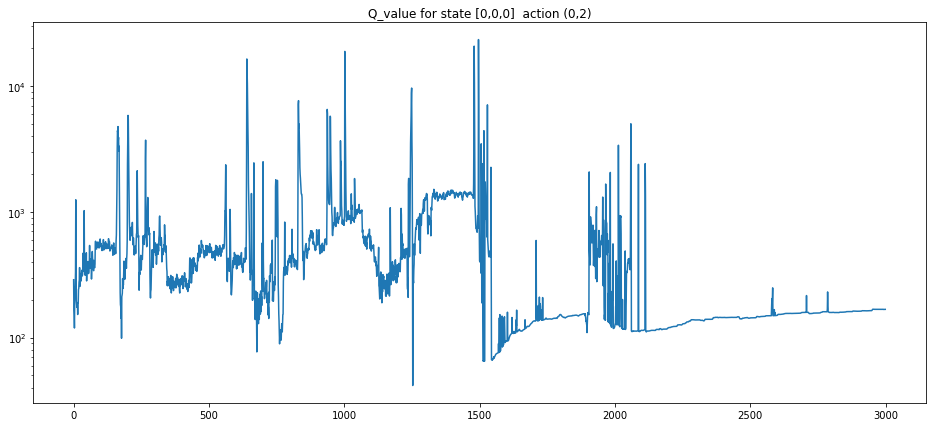

In [18]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

### Observation :---

  1. We are using log scale because the initial q_values are very high as compared to the steady state value.


### Track rewards per episode.

In [19]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

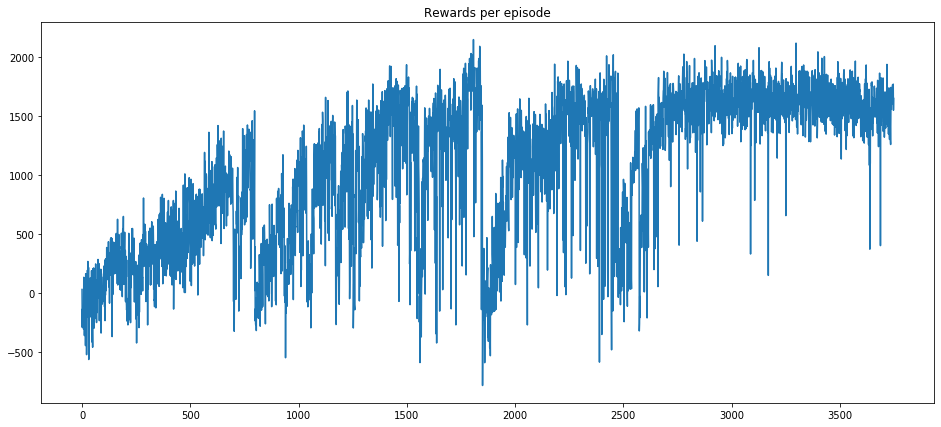

In [20]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

### Observation:---

  1. Above plot indicates that the rewards converge at around 1500. 
  

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [21]:
time = np.arange(0,15000)
epsilon = []
for i in range(0,15000):
    epsilon.append((1 - 0.00001) * np.exp(-0.0005 * i))

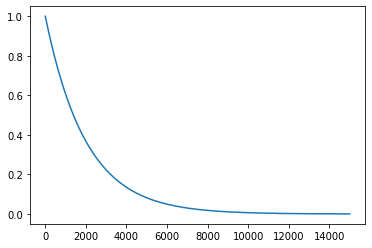

In [22]:
plt.plot(time, epsilon)
plt.show()